In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df=pd.read_csv("./data/TG_STAID002759.txt", parse_dates=True, index_col=1)
df.rename(columns = {' SOUID': 'source', '   TG':"temp", ' Q_TG': 'QTG'}, inplace=True)

In [3]:
missing = pd.date_range('1945-04-25', periods=195, freq='D')  # solution for loops from Aron
year44 = pd.date_range('1944-04-25', periods=195, freq='D')
year46 = pd.date_range('1946-04-25', periods=195, freq='D')
m=0
for i in tqdm(missing):
    df.loc[i,"temp"] = (df.loc[year44[m]]["temp"] + df.loc[year46[m]]["temp"]) / 2
    m += 1

In [4]:
df['tempK']=df['temp']*0.1+273.15 #Kelvin
df=df.drop(['QTG', 'source','temp'],axis=1) #removing all unnecessary columns
df = df[~((df.index.month == 2) & (df.index.day == 29))] #removing all 29 February

#### Decomposing

In [5]:
def decompose(df):
   
    df['diff_temp']=df['tempK'].diff() #trend
    df['monthly_mean'] = df.groupby(df.index.month)['diff_temp'].transform('mean')  #seasonality
    df['stationary_temp'] = df.diff_temp - df.monthly_mean  #noise
   
#     lag
#     week=list(range(1,8))
#     for day in week:
#         df[f'{day}_shifted_stationary_data'] = df['stationary_temp'] .shift(day)
#     df.fillna(method='bfill', inplace=True) 
    return df

In [6]:
decompose(df)

,tempK,diff_temp,monthly_mean,stationary_temp
DATE,,,,
1876-01-01,275.35,NaN,-0.005496,NaN
1876-01-02,275.65,0.3,-0.005496,0.305496
1876-01-03,273.45,-2.2,-0.005496,-2.194504
1876-01-04,267.35,-6.1,-0.005496,-6.094504
1876-01-05,263.35,-4.0,-0.005496,-3.994504
...,...,...,...,...
2020-07-27,293.85,2.0,0.034772,1.965228
2020-07-28,296.15,2.3,0.034772,2.265228
2020-07-29,292.35,-3.8,0.034772,-3.834772


#### Future

In [7]:
mon = 2
y_future = pd.DataFrame(index = pd.date_range(start='31 July 2020', periods = 30*mon, freq='D'),
             data=[0]*30*mon,
             columns=['daily_mean'])

In [8]:
y_future

,daily_mean
2020-07-31,0
2020-08-01,0
2020-08-02,0
2020-08-03,0
2020-08-04,0
2020-08-05,0
2020-08-06,0
2020-08-07,0
2020-08-08,0
2020-08-09,0


In [9]:
y_future.iloc[0, 0] = df.tempK[-1]

In [10]:
tr=df.iloc[-3650:-365]
mean_training = tr.groupby(tr.index.day)['diff_temp'].transform('mean')
y_future.iloc[1:] = mean_training[0:(30*mon)-1].values.reshape(-1,1)

In [11]:
y_future['Prediction'] = np.cumsum(y_future['daily_mean'])

In [12]:
y_future

,daily_mean,Prediction
2020-07-31,293.450000,293.450000
2020-08-01,-0.238889,293.211111
2020-08-02,-0.148148,293.062963
2020-08-03,0.430556,293.493519
2020-08-04,0.233333,293.726852
2020-08-05,-0.030556,293.696296
2020-08-06,-0.031481,293.664815
2020-08-07,0.153704,293.818519
2020-08-08,0.185185,294.003704
2020-08-09,-0.100926,293.902778


Text(0.5, 1.0, 'Prediction of temperature in Kelvin for August and September 2020')

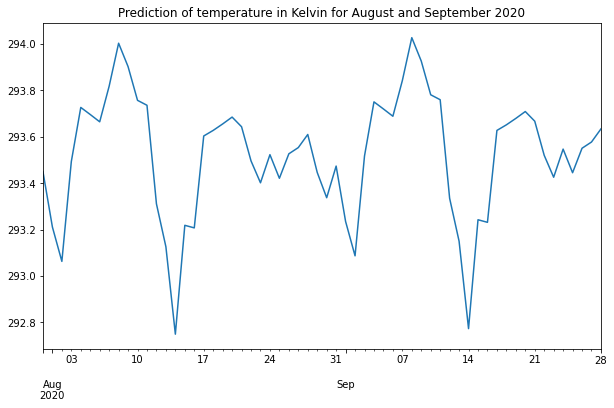

In [13]:
y_future['Prediction'].plot()
plt.title('Prediction of temperature in Kelvin for August and September 2020')

In [14]:
y_future['Prediction']=y_future['Prediction']-273

Text(0.5, 1.0, 'Amazing prediction')

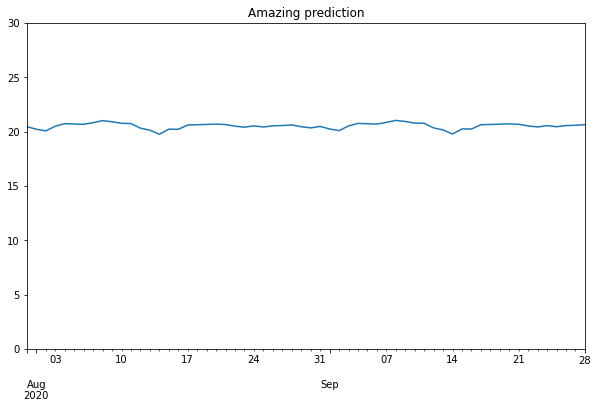

In [15]:
y_future['Prediction'].plot()
plt.ylim(0,30)
plt.title('Amazing prediction')